In [1]:
%config Completer.use_jedi = False

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import scipy
import os

In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [3]:
model.compile?

Object `model.compile` not found.


In [4]:
keras.applications.Xception?

## Model structure

In [44]:
base_model = keras.applications.ResNet50(weights="imagenet", include_top=False)

# base_model = keras.applications.Xception(weights="imagenet", include_top=False)
# base_model = keras.applications.MobileNetV2(weights="imagenet", include_top=False,input_shape=(224,224,3))
# base_model = keras.applications.EfficientNetB7(weights="imagenet", include_top=False,input_shape=(224,224,3))


base_model.trainable = False


inputs = keras.Input(shape=(224,224,3))
# inputs = keras.Input(shape=(299,299,3))


x = base_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)
# # x = keras.layers.Flatten()(x)
# x = keras.layers.Dropout(0.2)(x)
# x = keras.layers.Dense(128, activation='relu',kernel_regularizer=keras.regularizers.L1(0.01))(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(32, activation='relu',kernel_regularizer=keras.regularizers.L1(0.01))(x)

# x = keras.layers.Dense(8, activation='relu')(x)
outputs = keras.layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [45]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                65568     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                           

## Read Data

In [5]:
os.getcwd()

'/Users/zoey/Dropbox (University of Michigan)/1A_research (organized)/_Ideation/2_InterpretableAI/5_Lab (shared w RA)/2_analysis'

In [6]:
df_data=pd.read_csv('df_selected_final.csv',sep=',',header=0)
df_data.head()

,Unnamed: 0,zpid,time,price,week,dow,month,year,latitude,longitude,...,unitCount,stories,lastRemodelYear,solarPotential,zestimate,zestimateHighPercent,zestimateLowPercent,rentZestimate,taxEstimate,n_round
0,15,11252639,2020-07-30,329600,31,Thursday,7,20,40.390975,-80.067424,...,0,1,1959,86.82,388800,8,7,2504,561800,69
1,18,11252786,2020-11-16,787000,47,Monday,11,20,40.387805,-80.072098,...,0,2,1958,90.02,884800,6,6,3830,722659,69
2,19,11252802,2020-06-24,504715,26,Wednesday,6,20,40.388525,-80.068769,...,0,1,1948,92.42,600200,8,7,3894,626265,69
3,20,11253008,2020-06-22,755000,26,Monday,6,20,40.386178,-80.070577,...,0,2,1977,87.62,901300,8,7,5751,1102648,69
4,21,11253033,2020-10-01,800000,40,Thursday,10,20,40.385030,-80.068198,...,0,2,1953,88.42,918100,7,6,3160,629218,69


In [7]:
df_data.shape

(853, 35)

In [21]:
import glob

list_all_pic=glob.glob('../1_images/*/0*.jp*')+glob.glob('../1_images/*/*/0*.jp*')+ glob.glob('../1_images/*/*/*/0*.jp*')
list_all_pic_filtered=[i for i in list_all_pic if ('_' not in i.split('/')[-2]) and ('nan' not in i.split('/')[-2])]
dict_zpid_pic_path={int(i.split('/')[-2]):i for i in list_all_pic_filtered}
len(list_all_pic),len(list_all_pic_filtered)


In [24]:
df_data['pic_path']=df_data['zpid'].apply(lambda x: dict_zpid_pic_path[x] if x in dict_zpid_pic_path else "NA")
df_data_filtered=df_data[df_data['pic_path']!='NA']
df_data_filtered.shape

In [28]:
df_data_filtered['price_log'] = df_data_filtered['price'].apply(np.log)

/var/folders/bz/852ln1kj2073x6xn7tlhct840000gn/T/ipykernel_29035/3301692784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_filtered['price_log'] = df_data_filtered['price'].apply(np.log)


## Pre-process

In [27]:
images=[keras.preprocessing.image.load_img(i, target_size=(224, 224)) for i in df_data_filtered['pic_path']]
# images=[keras.preprocessing.image.load_img(i, target_size=(299, 299)) for i in df_data_filtered['pic_path']]
images=[keras.preprocessing.image.img_to_array(i) for i in images]
images=np.array(images)
# image = np.expand_dims(image, axis=0)
images = keras.applications.resnet50.preprocess_input(images)
# images = keras.applications.xception.preprocess_input(images)
# images = keras.applications.mobilenet_v2.preprocess_input(images)
# images = keras.applications.efficientnet.preprocess_input(images)


In [29]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# train_imgs=images[:-50]
# val_imgs=images[-50:]
# # train_price=np.array(df_data_filtered['price'].tolist()[:-50])/1e5
# # val_price=np.array(df_data_filtered['price'].tolist()[-50:])/1e5
# train_price=np.array(df_data_filtered['price'].tolist()[:-50])/1e6
# val_price=np.array(df_data_filtered['price'].tolist()[-50:])/1e6

train_imgs, val_imgs, train_price, val_price = train_test_split(images, 
                                                                np.array(df_data_filtered['price_log'].tolist())/1e6,
                                                                test_size=0.3, random_state=66)
standard_scaler = preprocessing.StandardScaler()
train_price = standard_scaler.fit_transform(train_price.reshape(-1, 1))
val_price = standard_scaler.transform(val_price.reshape(-1, 1))

# min_max_scaler = preprocessing.MinMaxScaler()
# train_price = min_max_scaler.fit_transform(train_price.reshape(-1, 1))
# val_price = min_max_scaler.transform(val_price.reshape(-1, 1))

In [30]:
max(train_price)

array([2.76680365])

## Model Training

In [46]:
history = model.fit(x=train_imgs, y=train_price,
                    validation_data=(val_imgs, val_price),
                    batch_size=30,
                    epochs=50,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=5)],
                    verbose=1)

Epoch 1/50
16/16 [==============================] - 20s 1s/step - loss: 19.6124 - root_mean_squared_error: 1.6301 - val_loss: 16.8458 - val_root_mean_squared_error: 1.0093
Epoch 2/50
16/16 [==============================] - 18s 1s/step - loss: 15.7553 - root_mean_squared_error: 0.9991 - val_loss: 14.4883 - val_root_mean_squared_error: 1.0089
Epoch 3/50
16/16 [==============================] - 18s 1s/step - loss: 13.4530 - root_mean_squared_error: 0.9999 - val_loss: 12.3198 - val_root_mean_squared_error: 1.0089
Epoch 4/50
16/16 [==============================] - 18s 1s/step - loss: 11.4700 - root_mean_squared_error: 1.0000 - val_loss: 10.5524 - val_root_mean_squared_error: 1.0088
Epoch 5/50
16/16 [==============================] - 18s 1s/step - loss: 9.8374 - root_mean_squared_error: 0.9985 - val_loss: 9.0750 - val_root_mean_squared_error: 1.0088
Epoch 6/50
16/16 [==============================] - 18s 1s/step - loss: 8.4791 - root_mean_squared_error: 0.9962 - val_loss: 7.8399 - val_root

In [221]:
# for ind,i in enumerate(predict_prices):
#     print("%.3f" % i[0],val_price[ind])

## Results explore

7/7 [==============================] - 6s 782ms/step


<AxesSubplot:>

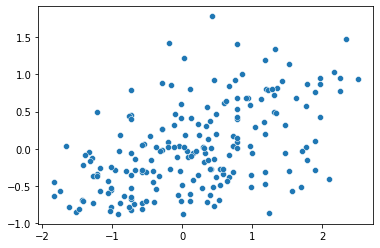

In [47]:
import seaborn as sns

predict_prices=model.predict(val_imgs)
sns.scatterplot(y=predict_prices.flatten(),x=val_price.flatten())

In [38]:
#sns.scatterplot(y=np.exp(predict_prices.flatten()),x=np.exp(val_price.flatten()))

In [48]:
np.mean(abs(predict_prices.flatten() - val_price.flatten())/abs(val_price.flatten()))

4.264459810798151

In [49]:
np.mean(abs(np.exp(predict_prices.flatten()) - np.exp(val_price.flatten()))/abs(np.exp(val_price.flatten())))

0.7253081359921483

In [50]:
scipy.stats.pearsonr(predict_prices.flatten(),val_price.flatten())

(0.5064909584515412, 1.7055982339520176e-14)

15/15 [==============================] - 12s 821ms/step


<AxesSubplot:>

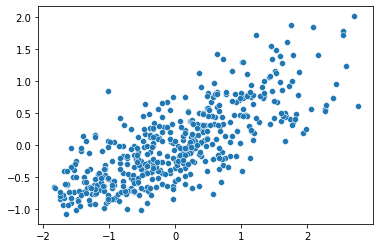

In [51]:
predict_prices=model.predict(train_imgs)

sns.scatterplot(y=predict_prices.flatten(),x=train_price.flatten())

In [52]:
np.mean(abs(predict_prices.flatten() - train_price.flatten())/abs(train_price.flatten()))

1.8273510339370604

In [53]:
np.mean(abs(np.exp(predict_prices.flatten()) - np.exp(train_price.flatten()))/abs(np.exp(train_price.flatten())))

0.5843214316430447

In [54]:
scipy.stats.pearsonr(predict_prices.flatten(),train_price.flatten())

(0.7686387312027855, 4.464703971682863e-92)

## Output layer information

In [56]:
layer_name = 'dense_2'
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)



In [57]:
intermediate_output = intermediate_layer_model(images)


In [58]:
intermediate_output.shape

TensorShape([667, 32])

In [65]:
df_out_feature=pd.DataFrame(np.array(intermediate_output),index=df_data_filtered['zpid'].to_list(),columns=['feature_%d' % i for i in range(1,33)])

In [76]:
df_out_feature.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,zpid
11252639,0.0,0.0,0.0,0.0,0.0,0.0,0.378165,0.016716,0.0,0.0,...,0.0,0.0,0.0,5.599988,0.0,2.597314,0.0,0.0,0.0,11252639
11252786,0.0,0.0,0.0,0.0,0.0,0.0,0.648060,0.000000,0.0,0.0,...,0.0,0.0,0.0,5.091343,0.0,3.047146,0.0,0.0,0.0,11252786
11252802,0.0,0.0,0.0,0.0,0.0,0.0,0.580727,0.000000,0.0,0.0,...,0.0,0.0,0.0,5.604352,0.0,2.958225,0.0,0.0,0.0,11252802
11253008,0.0,0.0,0.0,0.0,0.0,0.0,0.181797,0.000000,0.0,0.0,...,0.0,0.0,0.0,4.711068,0.0,4.313328,0.0,0.0,0.0,11253008
11253033,0.0,0.0,0.0,0.0,0.0,0.0,0.109157,0.000000,0.0,0.0,...,0.0,0.0,0.0,5.789567,0.0,2.809074,0.0,0.0,0.0,11253033


In [68]:
df_out_feature['feature_2'].unique()

array([0.], dtype=float32)

In [75]:
df_out_feature['zpid']=df_out_feature.index

In [77]:
df_out_feature.to_csv('TL_features.csv',sep=',',header=True,index=False)

In [72]:
df_temp=df_out_feature.describe()

In [74]:
df_temp.loc['std']

feature_1     0.000000
feature_2     0.000000
feature_3     0.000000
feature_4     0.011571
feature_5     0.000000
feature_6     0.001394
feature_7     0.237315
feature_8     0.116939
feature_9     0.092806
feature_10    0.000000
feature_11    0.000000
feature_12    0.147738
feature_13    0.000000
feature_14    0.000000
feature_15    0.218861
feature_16    0.098243
feature_17    0.000000
feature_18    0.000257
feature_19    0.000000
feature_20    0.000000
feature_21    0.000000
feature_22    0.000000
feature_23    0.000000
feature_24    0.000000
feature_25    0.000000
feature_26    0.000000
feature_27    0.906273
feature_28    0.000276
feature_29    1.113338
feature_30    0.003006
feature_31    0.002205
feature_32    0.000000
Name: std, dtype: float64

## Test

In [44]:
imagePath='/1_image_zoey_1_50/11311273/0.jpeg'

image = keras.preprocessing.image.load_img(imagePath, target_size=(224, 224))


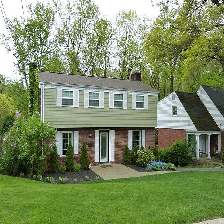

In [45]:
image

In [46]:
image = keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)
image = keras.applications.resnet50.preprocess_input(image)


In [47]:
image.shape

(1, 224, 224, 3)

In [17]:
keras.applications.resnet50.preprocess_input?

In [48]:
features = base_model.predict(image)
# features = features.reshape((features.shape[0], 7 * 7 * 2048))
features = features.reshape((features.shape[0], -1))

1/1 [==============================] - 1s 786ms/step


In [49]:
features.shape

(1, 62720)

In [50]:
pd.Series(features[0,:]).value_counts()

0.000000    50693
6.000000     1008
0.781738        2
2.759888        2
2.154566        2
            ...  
2.092931        1
2.402520        1
2.461208        1
1.047091        1
4.464641        1
Length: 11015, dtype: int64

In [29]:
import pandas as pd

In [32]:
keras.applications.ResNet50?